### Independent Work: FruitNet Implementation

Author: Tyler Kaye - Editted From COS 495 Project


In [1]:
# automatically reload edited modules
%load_ext autoreload
%autoreload 2

In [2]:
import os
import tarfile
import random
import tarfile
from six.moves import urllib
import tensorflow as tf
import numpy as np
from copy import deepcopy

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display

#### Download the Apples data if necesssary (163 M)

In [4]:
# # Check if file exists, otherwise download it
# data_file = os.path.join('apples-batches-python.tar.gz')
# if os.path.isfile(data_file):
#     tar = tarfile.open(data_file, "r:gz")
#     tar.extractall()
#     tar.close()
#     pass

#### Prepare Apples-10 data

In [5]:
import prepare_apples_128 
apples = prepare_apples_128.read_data_sets(reshape=False)
categories = ["Bad", "Good"]

#### View some images and labels

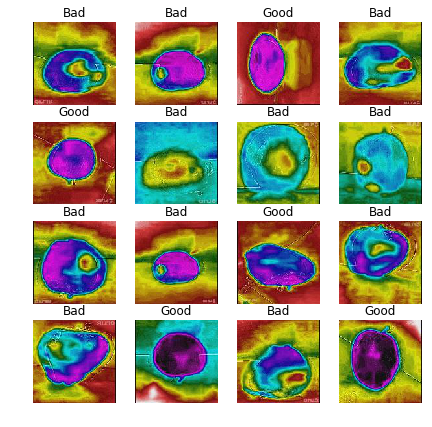

In [6]:
for i in range(16):
    plt.subplot(4,4,i+1)
    images = apples.train.images[i]
    plt.imshow(images, interpolation='nearest')
    label = np.argmax(apples.train.labels[i])
    plt.title(categories[label])
    plt.axis('off')
plt.gcf().set_size_inches(7,7)

#### Set input/output and training parameters

In [7]:
# Parameters
learning_rate = 0.001
training_iters = 1000
batch_size = 128
val_batch_size = 128
display_step = 10

# Network Parameters
input_shape = [128, 128, 3] # Apples data input
n_classes = 2 # Apple total classes
dropout = 0.9 # probability to keep units (1.0 indicates no dropout)

# tf Graph input
x = tf.placeholder(tf.float32, input_shape.insert(0, None))
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) # dropout keep probability

#### Define ConvNet wrapper functions

In [8]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

#### Define architecture

In [9]:
# Store layers weight & bias
_weights = {
    # 3x3 conv, 3 inputs, 32 outputs
    'wc1': tf.Variable(tf.random_normal([3, 3, 3, 32], stddev=0.05)),
    # 3x3 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.05)),
    # 3x3 conv, 64 inputs, 64 outputs
    'wc3': tf.Variable(tf.random_normal([3, 3, 64, 64], stddev=0.05)),
    # fully connected, 8*8*64 inputs, 512 outputs
    'wd1': tf.Variable(tf.random_normal([8*8*64, 512], stddev=0.05)),
    # fully connected, 512 inputs, 256 outputs
    'wd2': tf.Variable(tf.random_normal([512, 256], stddev=0.05)),
    # fully connected, 512 inputs, 2 outputs
    'out': tf.Variable(tf.random_normal([256, n_classes], stddev=0.05))
}

_biases = {
    'bc1': tf.Variable(tf.zeros([32])),
    'bc2': tf.Variable(tf.zeros([64])),
    'bc3': tf.Variable(tf.zeros([64])),
    'bd1': tf.Variable(tf.zeros([512])),
    'bd2': tf.Variable(tf.zeros([256])),
    'out': tf.Variable(tf.zeros([n_classes]))
}

In [10]:
# Create model (adapted from aymericdamien's "TensorFlow-Examples")
def convnet(x):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 128, 128, 3])

    # Convolution Layer
    with tf.name_scope('Conv1'):
        conv1 = conv2d(x, _weights['wc1'], _biases['bc1'])
        # Max Pooling (down-sampling)
        conv1 = maxpool2d(conv1, k=2)
        conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    with tf.name_scope('Conv2'):
        conv2 = conv2d(conv1, _weights['wc2'], _biases['bc2'])
        # Max Pooling (down-sampling)
        conv2 = maxpool2d(conv2, k=2)
    
    # Convolution Layer
    with tf.name_scope('Conv1'):
        conv3 = conv2d(conv2, _weights['wc3'], _biases['bc3'])
        # Max Pooling (down-sampling)
        conv3 = maxpool2d(conv3, k=2)

    # Fully connected layer
    # Reshape conv3 output to fit fully connected layer input
    with tf.name_scope('MLP1'):
        fc1 = tf.reshape(conv3, [-1, _weights['wd1'].get_shape().as_list()[0]])
        fc1 = tf.add(tf.matmul(fc1, _weights['wd1']), _biases['bd1'])
        fc1 = tf.nn.relu(fc1)
        # Apply Dropout
        fc1 = tf.nn.dropout(fc1, dropout)
    
    # Fully connected layer
    # Reshape conv3 output to fit fully connected layer input
    with tf.name_scope('MLP2'):
        fc2 = tf.add(tf.matmul(fc1, _weights['wd2']), _biases['bd2'])
        fc2 = tf.nn.relu(fc2)
        # Apply Dropout
        fc2 = tf.nn.dropout(fc2, dropout)
    
        # Output, class prediction
        out = tf.add(tf.matmul(fc2, _weights['out']), _biases['out'], name="output_node")    
    return out

#### Initialize network weights and set loss function

In [11]:
# Construct model
pred = convnet(x)

# Define loss and optimizer
soft = tf.nn.softmax(pred) # for interpretation only
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

#### Saving Help

In [12]:
checkpoint_state_name = "checkpoint_state"
input_graph_name = "input_graph.pb"
output_graph_name = "output_graph.pb"

# Create a saver.
saver = tf.train.Saver()

In [13]:
import freeze_graph

def freeze_my_graph(sess):

    tf.train.write_graph(sess.graph.as_graph_def(), os.getcwd(), input_graph_name)

    # We save out the graph to disk, and then call the const conversion routine.

    checkpoint_prefix = os.path.join(os.getcwd(), "saved_checkpoint")
    input_graph_path = os.path.join(os.getcwd(), input_graph_name)
    input_saver_def_path = ""
    input_binary = False
    input_checkpoint_path = checkpoint_prefix + "-0"
    # input_checkpoint_path = os.path.join(FLAGS.checkpoint_dir, 'model.ckpt') + "-0"
    # input_checkpoint_path = os.path.join(FLAGS.checkpoint_dir, 'model.ckpt-299')
    output_node_names = "MLP2/output_node"
    restore_op_name = "save/restore_all"
    filename_tensor_name = "save/Const:0"
    output_graph_path = os.path.join(os.getcwd(), output_graph_name)
    clear_devices = False
    
    freeze_graph.freeze_graph(input_graph_path,
                            input_saver_def_path,
                            input_binary,
                            input_checkpoint_path,
                            output_node_names,
                            restore_op_name,
                            filename_tensor_name,
                            output_graph_path,
                            clear_devices, "")

#### Begin training

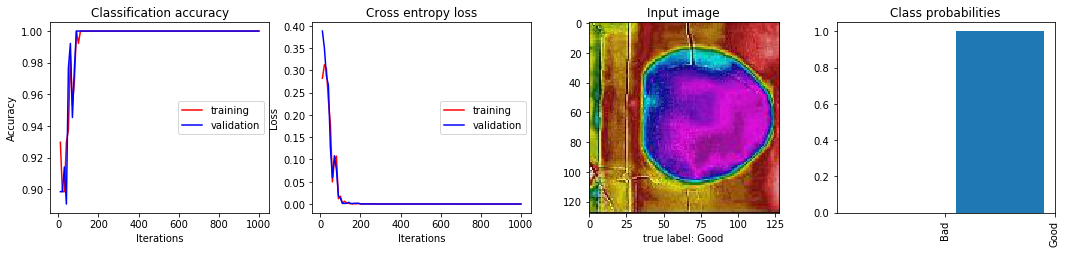

In [14]:
# accuracy/loss plotting helper function
def plot_learning(plot_handles, ylabel):
    plt.legend(handles=plot_handles, loc="center right")
    plt.xlabel("Iterations")
    plt.ylabel(ylabel)

# launch the graph
sess = tf.InteractiveSession()
sess.run(init)
step = 1

# initialize accuracy/loss arrays
train_acc = np.zeros(training_iters/display_step)
train_loss = np.zeros(training_iters/display_step)
val_acc = np.zeros(training_iters/display_step)
val_loss = np.zeros(training_iters/display_step)

# keep training until reach max iterations
while step <= training_iters:

    batch_x, batch_y = apples.train.next_batch(batch_size)
    # run optimization op (backprop)
    
    sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
    if step % display_step == 0:
        checkpoint_prefix = os.path.join(os.getcwd(), "saved_")
        saver.save(sess, checkpoint_prefix, global_step=0, latest_filename=checkpoint_state_name)
        plt.gcf().clear()
        
        # calculate batch loss and accuracy
        train_loss[step/display_step-1], train_acc[step/display_step-1] = sess.run([cost, accuracy], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})
        
        # Validation set
        val_batch_x, val_batch_y = apples.validation.next_batch(val_batch_size)
        val_loss[step/display_step-1], val_acc[step/display_step-1], this_soft, this_y = sess.run([cost, accuracy, soft, y], feed_dict={x: val_batch_x, y: val_batch_y, keep_prob: 1.})
        
        # Plot the training error / validation error 
        plt.subplot(1,4,1)
        train_plot, = plt.plot(range(display_step,step+1,display_step), train_acc[:step/display_step], 'r', label="training")
        val_plot, = plt.plot(range(display_step,step+1,display_step), val_acc[:step/display_step], 'b', label="validation")
        plot_learning([train_plot, val_plot], "Accuracy")
        plt.title("Classification accuracy")
        
        # PLot the Cross Entropy Loss
        plt.subplot(1,4,2)
        train_plot, = plt.plot(range(display_step,step+1,display_step), train_loss[:step/display_step], 'r', label="training")
        val_plot, = plt.plot(range(display_step,step+1,display_step), val_loss[:step/display_step], 'b', label="validation")
        plot_learning([train_plot, val_plot], "Loss")
        plt.title("Cross entropy loss")
        
        # Plot the current image
        plt.subplot(1,4,3)
        plt.imshow(val_batch_x[0], interpolation='nearest')
        plt.title("Input image")
        plt.xlabel("true label: " + categories[np.argmax(this_y[0])])
        
        # Plot the output of the softmax layer
        plt.subplot(1,4,4)
        plt.bar(np.arange(0,len(this_soft[0]),1), this_soft[0])
        plt.title("Class probabilities")
        plt.xticks(np.arange(0.5,len(categories),1), categories, rotation="vertical")
        
        plt.gcf().set_size_inches(18, 3.5)
        display.display(plt.gcf())
        wt1 = sess.run(_weights['wc1'])
        display.clear_output(wait=True)
    step += 1

In [ ]:
freeze_my_graph(sess)